In [1]:
#First Model. 
#No Data Augmentation
#No hyperparameters tunning

In [1]:
import numpy as np
import nibabel as nib
import glob
import os
import pandas as pd

import keras
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import scipy

import csv as csv

%matplotlib inline
import matplotlib.pyplot as plt

/Users/claugreco/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(keras.__version__)

2.1.4


In [3]:
df = pd.read_csv('data.csv')
df.shape

(493, 38402)

In [4]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,38391,38392,38393,38394,38395,38396,38397,38398,38399,label
0,0,0,0,0,3,4,13,11,15,9,...,0,0,0,0,0,0,0,0,0,35
1,1,9,3,1,3,11,5,1,9,14,...,0,1,1,0,0,0,0,0,0,38
2,2,11,9,5,1,1,5,5,1,1,...,0,0,0,0,0,0,0,0,3,46
3,3,0,0,11,8,6,6,1,3,10,...,0,3,0,0,1,0,0,1,0,34
4,4,0,0,16,26,22,19,6,3,0,...,0,0,0,0,0,0,0,0,0,24


In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
df.shape

(493, 38401)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,38391,38392,38393,38394,38395,38396,38397,38398,38399,label
0,0,0,0,3,4,13,11,15,9,6,...,0,0,0,0,0,0,0,0,0,35
1,9,3,1,3,11,5,1,9,14,12,...,0,1,1,0,0,0,0,0,0,38
2,11,9,5,1,1,5,5,1,1,1,...,0,0,0,0,0,0,0,0,3,46
3,0,0,11,8,6,6,1,3,10,3,...,0,3,0,0,1,0,0,1,0,34
4,0,0,16,26,22,19,6,3,0,0,...,0,0,0,0,0,0,0,0,0,24


In [8]:
y= df['label']
X= df.drop('label', axis=1)

In [9]:
#Rescale Data

scaler = MinMaxScaler(feature_range = (0,1))
X_scaled = scaler.fit_transform(X)

In [10]:
X_scaled.max()

1.0000000000000002

In [11]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=142)

# # Standardize Data
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

# X_train.shape

In [12]:
# Reshape 
X_train = X_train.reshape(X_train.shape[0], 256, 150, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 150, 1)

In [13]:
X_train.shape

(345, 256, 150, 1)

In [14]:
X_train.shape[1:]

(256, 150, 1)

In [15]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]-> MaxPool2D]*2 -> Dropout -> 
# Flatten -> Dense -> Dropout -> Out


# Define model architecture
model = Sequential()

#Convolutional layer1
#filters types are chosing automatically
model.add(Convolution2D(filters = 15,           
                        kernel_size = (5,5),    
                        strides=(1, 1),         
                        activation='relu', 
                        input_shape=(256,150,1)))

#model.add(BatchNormalization())

#Pooling layer1
model.add(MaxPooling2D(pool_size=(2,2),
                      strides=(2, 2)))     


#Convolutional layer2
model.add(Convolution2D(filters =30,        
                        kernel_size = (4,4),   
                        activation='relu'))
#model.add(BatchNormalization())

#Pooling layer2
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))  #Regularization
 
#Before passing to the fully conected network, we need to flatten
model.add(Flatten())

#Add a densily connected layer
model.add(Dense(1000, activation='relu'))     
#model.add(BatchNormalization()) 

model.add(Dropout(0.5))

#Add a densily connected layer --> output layer use relu,
model.add(Dense(1, activation='relu'))


# Compile model --> loss function is mae

model.compile(loss='mae',
              optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')



In [16]:
%%timeit -n1 -r1
# Fit model on training data

model.fit(X_train, y_train, 
          batch_size=128,
          epochs=50, 
          callbacks=[early_stop], 
          validation_data =(X_test, y_test),
          verbose=1)

Train on 345 samples, validate on 148 samples
Epoch 1/50
345/345 [==============================] - 24s 71ms/step - loss: 38.7343 - val_loss: 29.1511
Epoch 2/50
345/345 [==============================] - 19s 55ms/step - loss: 27.0962 - val_loss: 27.0130
Epoch 3/50
345/345 [==============================] - 19s 55ms/step - loss: 25.3852 - val_loss: 23.2333
Epoch 4/50
345/345 [==============================] - 19s 55ms/step - loss: 21.6815 - val_loss: 20.2067
Epoch 5/50
345/345 [==============================] - 19s 54ms/step - loss: 17.2843 - val_loss: 16.0923
Epoch 6/50
345/345 [==============================] - 20s 58ms/step - loss: 13.6664 - val_loss: 13.3096
Epoch 7/50
345/345 [==============================] - 20s 57ms/step - loss: 12.0889 - val_loss: 14.0911
Epoch 8/50
345/345 [==============================] - 19s 56ms/step - loss: 12.6783 - val_loss: 12.4417
Epoch 9/50
345/345 [==============================] - 20s 57ms/step - loss: 11.9187 - val_loss: 12.3090
Epoch 10/50
345/34

In [17]:
# Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)

In [18]:
preds = model.predict(X_test)

preds_train = model.predict(X_train)

In [47]:
min(y_test)

20

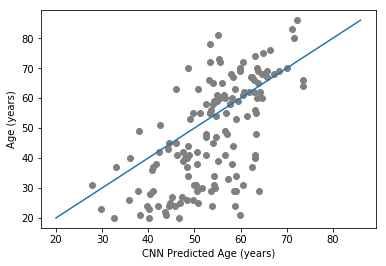

In [54]:
plt.scatter(preds, y_test, color='gray');
plt.xlabel('CNN Predicted Age (years)')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)])
plt.ylabel('Age (years)')
plt.show()

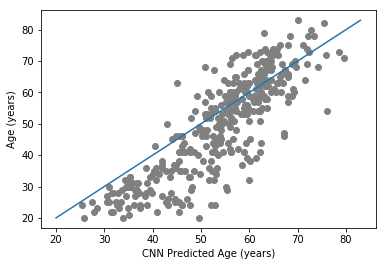

In [55]:
plt.scatter(preds_train, y_train, color='gray');
plt.xlabel('CNN Predicted Age (years)')
plt.ylabel('Age (years)')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)])
plt.show()

In [24]:
print(score)

11.381977648348421


In [25]:
r_score = r2_score(y_test, preds)
print (r_score)

0.30304900827936954


In [26]:
r_score = r2_score(y_train, preds_train)
print (r_score)

0.6192463616587662


In [27]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 146, 15)      390       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 73, 15)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 70, 30)       7230      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 35, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 35, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64050)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              64051000  
__________

In [50]:
mean_age = y.mean()

In [51]:
baseline = np.ones((y_test.shape[0],1))*mean_age

In [52]:
mean_absolute_error(y_test,baseline)

15.306013924675183

In [53]:
mean_absolute_error(y_test,preds)

11.381977699898385